In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from scipy import stats
from scipy.stats import chi2_contingency, mannwhitneyu, ttest_ind
import math

In [2]:
train = pd.read_csv("data/loan_train.csv", delimiter= ",", encoding= "utf-8")
test = pd.read_csv("data/loan_test.csv", delimiter= ",", encoding= "utf-8")

In [3]:
train

,Gender,Married,Dependents,Education,Self_Employed,Applicant_Income,Coapplicant_Income,Loan_Amount,Term,Credit_History,Area,Status
0,Male,No,0,Graduate,No,584900,0.0,15000000,360.0,1.0,Urban,Y
1,Male,Yes,1,Graduate,No,458300,150800.0,12800000,360.0,1.0,Rural,N
2,Male,Yes,0,Graduate,Yes,300000,0.0,6600000,360.0,1.0,Urban,Y
3,Male,Yes,0,Not Graduate,No,258300,235800.0,12000000,360.0,1.0,Urban,Y
4,Male,No,0,Graduate,No,600000,0.0,14100000,360.0,1.0,Urban,Y
...,...,...,...,...,...,...,...,...,...,...,...,...
609,Female,No,0,Graduate,No,290000,0.0,7100000,360.0,1.0,Rural,Y
610,Male,Yes,3+,Graduate,No,410600,0.0,4000000,180.0,1.0,Rural,Y
611,Male,Yes,1,Graduate,No,807200,24000.0,25300000,360.0,1.0,Urban,Y
612,Male,Yes,2,Graduate,No,758300,0.0,18700000,360.0,1.0,Urban,Y


In [4]:
test

,Gender,Married,Dependents,Education,Self_Employed,Applicant_Income,Coapplicant_Income,Loan_Amount,Term,Credit_History,Area
0,Male,Yes,0,Graduate,No,572000,0,11000000,360.0,1.0,Urban
1,Male,Yes,1,Graduate,No,307600,150000,12600000,360.0,1.0,Urban
2,Male,Yes,2,Graduate,No,500000,180000,20800000,360.0,1.0,Urban
3,Male,Yes,2,Graduate,No,234000,254600,10000000,360.0,NaN,Urban
4,Male,No,0,Not Graduate,No,327600,0,7800000,360.0,1.0,Urban
...,...,...,...,...,...,...,...,...,...,...,...
362,Male,Yes,3+,Not Graduate,Yes,400900,177700,11300000,360.0,1.0,Urban
363,Male,Yes,0,Graduate,No,415800,70900,11500000,360.0,1.0,Urban
364,Male,No,0,Graduate,No,325000,199300,12600000,360.0,NaN,Semiurban
365,Male,Yes,0,Graduate,No,500000,239300,15800000,360.0,1.0,Rural


# Pré Tratamento Dados

In [5]:
scaler = MinMaxScaler()

def transform_data (df) : 
    
    df_aux = df.copy()
    
    df_aux['Married'] = np.where(df_aux['Married'] == 'Yes', 1, 0)
    
    df_aux['Male'] = np.where(df_aux['Gender'] == 'Male', 1, 0)
    
    df_aux['Graduate'] = np.where(df_aux['Education'] == 'Graduate', 1, 0)
    
    df_aux['Self_Employed'] = np.where(df_aux['Self_Employed'] == 'Yes', 1, 0)
    
    #tratamento to_numeric + coerce = trata para que todos os dados sejam numericos, e os nulos se tornam NaN
    #fillna(df_aux['Dependents'].mode().iloc[0]) == Substituir os NaNs pela valor mais frequente da coluna
    df_aux['Dependents'] = np.where(df_aux['Dependents'] == '3+', 3, df_aux['Dependents'])
    df_aux['Dependents'] = pd.to_numeric(df_aux['Dependents'], errors='coerce').fillna(df_aux['Dependents'].mode().iloc[0]).astype(int)
    
    df_aux['Term_360'] = np.where(df_aux['Term'] == 360, 1, 0)
    
    df_aux['Credit_History'] = np.where(df_aux['Credit_History'] == 1, 1, 0)

    df_aux = df_aux.drop(['Gender', 'Education', 'Term'], axis=1)
    
    #Normalização dos dados caso necessario
    #df_aux[['Applicant_Income', 'Coapplicant_Income', 'Loan_Amount', 'Term']] = scaler.fit_transform(df_aux[['Applicant_Income', 'Coapplicant_Income', 'Loan_Amount', 'Term']])
    
    return df_aux

In [6]:
train_trat_v1 = transform_data(train)
train_trat_v1['Status'] = np.where(train_trat_v1['Status'] == 'Y', 0, 1)

test_trat_v1 = transform_data(test)

In [7]:
train_trat_v1

,Married,Dependents,Self_Employed,Applicant_Income,Coapplicant_Income,Loan_Amount,Credit_History,Area,Status,Male,Graduate,Term_360
0,0,0,0,584900,0.0,15000000,1,Urban,0,1,1,1
1,1,1,0,458300,150800.0,12800000,1,Rural,1,1,1,1
2,1,0,1,300000,0.0,6600000,1,Urban,0,1,1,1
3,1,0,0,258300,235800.0,12000000,1,Urban,0,1,0,1
4,0,0,0,600000,0.0,14100000,1,Urban,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
609,0,0,0,290000,0.0,7100000,1,Rural,0,0,1,1
610,1,3,0,410600,0.0,4000000,1,Rural,0,1,1,0
611,1,1,0,807200,24000.0,25300000,1,Urban,0,1,1,1
612,1,2,0,758300,0.0,18700000,1,Urban,0,1,1,1


# AED

In [8]:
train_trat_v1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Married             614 non-null    int32  
 1   Dependents          614 non-null    int32  
 2   Self_Employed       614 non-null    int32  
 3   Applicant_Income    614 non-null    int64  
 4   Coapplicant_Income  614 non-null    float64
 5   Loan_Amount         614 non-null    int64  
 6   Credit_History      614 non-null    int32  
 7   Area                614 non-null    object 
 8   Status              614 non-null    int32  
 9   Male                614 non-null    int32  
 10  Graduate            614 non-null    int32  
 11  Term_360            614 non-null    int32  
dtypes: float64(1), int32(8), int64(2), object(1)
memory usage: 38.5+ KB


In [9]:
train_trat_v1.describe()

,Married,Dependents,Self_Employed,Applicant_Income,Coapplicant_Income,Loan_Amount,Credit_History,Status,Male,Graduate,Term_360
count,614.000000,614.000000,614.000000,6.140000e+02,6.140000e+02,6.140000e+02,614.000000,614.000000,614.000000,614.000000,614.000000
mean,0.648208,0.744300,0.133550,5.403459e+05,1.621246e+05,1.414104e+07,0.773616,0.312704,0.796417,0.781759,0.833876
std,0.477919,1.009623,0.340446,6.109042e+05,2.926248e+05,8.815682e+06,0.418832,0.463973,0.402991,0.413389,0.372495
min,0.000000,0.000000,0.000000,1.500000e+04,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,2.877500e+05,0.000000e+00,9.800000e+06,1.000000,0.000000,1.000000,1.000000,1.000000
50%,1.000000,0.000000,0.000000,3.812500e+05,1.188500e+05,1.250000e+07,1.000000,0.000000,1.000000,1.000000,1.000000
75%,1.000000,1.000000,0.000000,5.795000e+05,2.297250e+05,1.647500e+07,1.000000,1.000000,1.000000,1.000000,1.000000
max,1.000000,3.000000,1.000000,8.100000e+06,4.166700e+06,7.000000e+07,1.000000,1.000000,1.000000,1.000000,1.000000


## Frequência - Variáveis binárias/quali

In [10]:
def grafico_frequencias (base, coluna) :
    
    #Calculo do share de sucessos dentro das Areas
    percentages = base[train_trat_v1['Status'] == 1].groupby(coluna).size() / base.groupby(coluna).size()
    percentages *= 100

    # Plotar o gráfico de barras
    fig, ax1 = plt.subplots()

    # Barras
    counts = (base[coluna].value_counts(normalize=True) * 100).round(2)
    counts.plot.bar(ax=ax1, color='gray')
    ax1.set_ylabel('Volume de Observações %')
    ax1.set_xlabel(coluna)
    ax1.set_title('Volume de Observações')

    # Criar o segundo eixo vertical
    ax2 = ax1.twinx()

    # Linha
    percentages.plot.line(ax=ax2, marker='o', color='red')
    ax2.set_ylabel('Percentual (%) de sucessos')

    # Definir limites do eixo vertical da linha
    ax2.set_ylim(0, 100)

    # Adicionar rótulos das barras
    for i, v in enumerate(counts):
        ax1.text(i, v - 5, f'{v:.1f}', ha='center', color='white', fontweight='bold')

    # Adicionar rótulos da linha
    for i, v in enumerate(percentages):
        ax2.text(i, v+2, f'{v:.1f}%', ha='center', color='black', fontweight='bold')
    
    # Definir a ordem dos valores no eixo X
    plt.xticks(range(len(counts.index)), counts.index)

    return plt.show()

- Variavel Alvo

In [11]:
total_counts = train_trat_v1['Status'].value_counts(normalize=True) * 100
total_counts.round(2)

0    68.73
1    31.27
Name: Status, dtype: float64

- Variavel Married

In [12]:
# Distribuição percentual da coluna para a base como um todo
# normalize=True ==> % do Total || normalize=False ==> Contagem 
total_counts = train_trat_v1['Married'].value_counts(normalize=True) * 100
total_counts.round(2)

1    64.82
0    35.18
Name: Married, dtype: float64

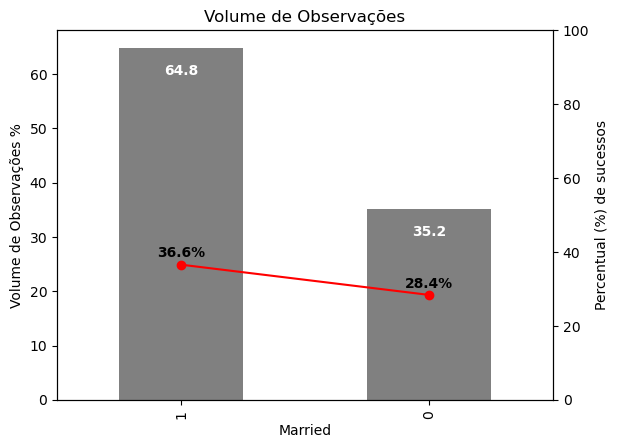

In [13]:
grafico_frequencias(train_trat_v1, 'Married')

- Variavel Dependents

In [14]:
total_counts = train_trat_v1['Dependents'].value_counts(normalize=True) * 100
total_counts.round(2)

0    58.63
1    16.61
2    16.45
3     8.31
Name: Dependents, dtype: float64

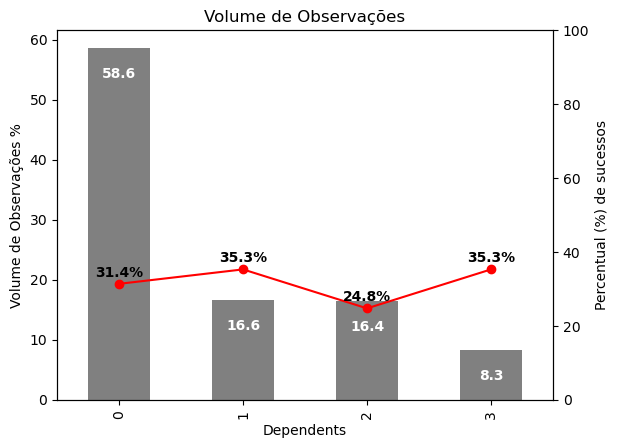

In [15]:
grafico_frequencias(train_trat_v1, 'Dependents')

- Variavel Credit_History

In [16]:
total_counts = train_trat_v1['Credit_History'].value_counts(normalize=True) * 100
total_counts.round(2)

1    77.36
0    22.64
Name: Credit_History, dtype: float64

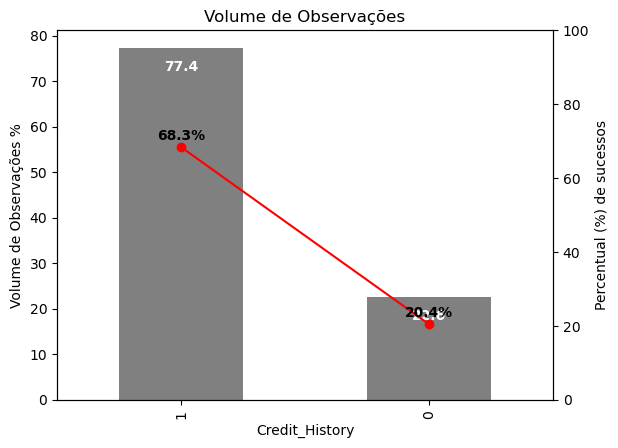

In [17]:
grafico_frequencias(train_trat_v1, 'Credit_History')

- Variavel Male

In [18]:
total_counts = train_trat_v1['Male'].value_counts(normalize=True) * 100
total_counts.round(2)

1    79.64
0    20.36
Name: Male, dtype: float64

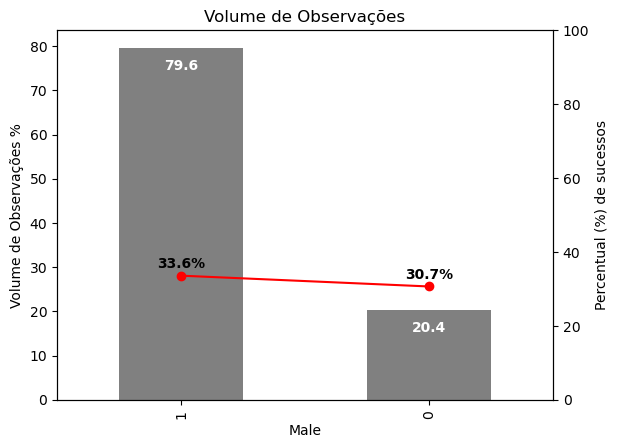

In [19]:
grafico_frequencias(train_trat_v1, 'Male')

- Variavel Graduate

In [20]:
total_counts = train_trat_v1['Graduate'].value_counts(normalize=True) * 100
total_counts.round(2)

1    78.18
0    21.82
Name: Graduate, dtype: float64

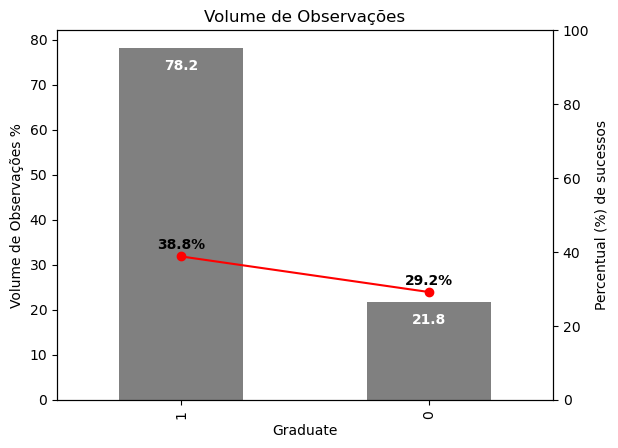

In [21]:
grafico_frequencias(train_trat_v1, 'Graduate')

- Variavel Term_360

In [22]:
total_counts = train_trat_v1['Term_360'].value_counts(normalize=True) * 100
total_counts.round(2)

1    83.39
0    16.61
Name: Term_360, dtype: float64

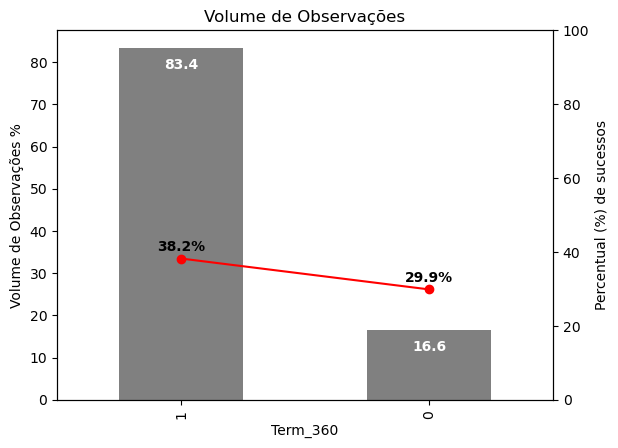

In [23]:
grafico_frequencias(train_trat_v1, 'Term_360')

 - Variavel Self Employed

In [24]:
total_counts = train_trat_v1['Self_Employed'].value_counts(normalize=True) * 100
total_counts.round(2)

0    86.64
1    13.36
Name: Self_Employed, dtype: float64

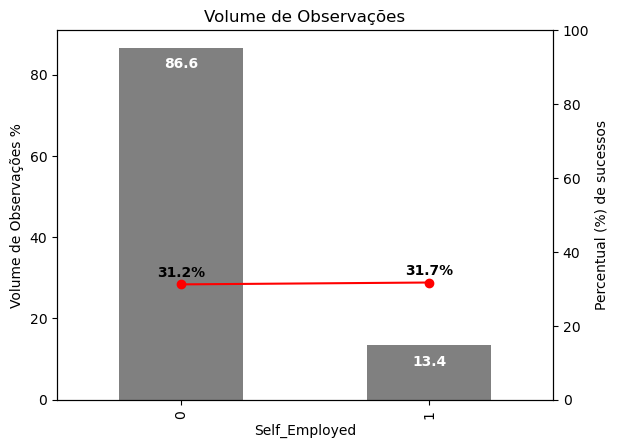

In [25]:
grafico_frequencias(train_trat_v1, 'Self_Employed')

 - Variavel Area

In [26]:
total_counts = train_trat_v1['Area'].value_counts(normalize=True) * 100
total_counts.round(2)

Semiurban    37.95
Urban        32.90
Rural        29.15
Name: Area, dtype: float64

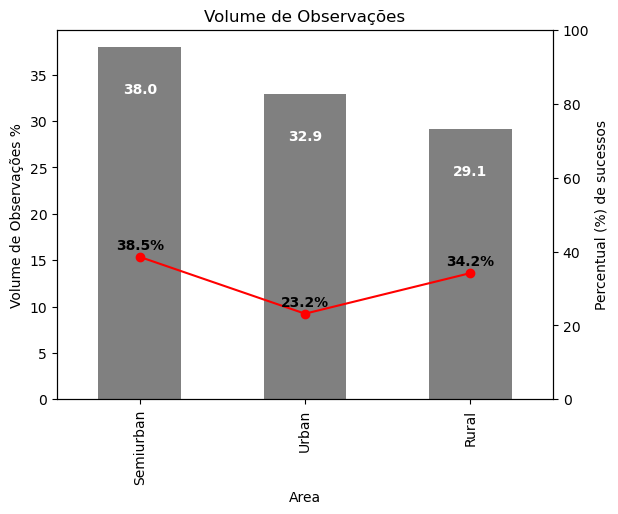

In [27]:
grafico_frequencias(train_trat_v1, 'Area')

 ## Resumo Frequencias : 
     
    Qualitativas :
 
    Status 1 (Empréstimo aceito) = 30% da base de treino
    
    Credit_History : *Associação evidente*
    All - 84% possui historico de antigos créditos.
    Possuem antigos créditos = 68% aceito
    Não possuem antigos créditos = 20% aceito 

    Married :  *Possível associação ?*
    Casados = 64% do total
    Casados = 37% aceitos
    Solteiros = 28% aceitos
    
    Graduate : *Possível associação ?*
    Graduados = 78% do total
    Graduados = 39% de aceitos.
    Não Graduados = 29% de aceitos.
    
    Term_360 : *Possível associação ?*
    Pagamento em 360 dias - 83% do total
    Pagamento em 360 dias - 38% de aceitos
    Pagamento em periodos menores  - 29% de aceitos
    
    Area : *Possível Associação*
    Semi Urban e Rural variam bastante a partir de Y
        Urban      -> 2
        Semi Urban -> All : 38% -> y1 : 28% -> y0 : 42%
        Rural      -> All : 29% -> y1 : 36% -> y0 : 26%

    Dependentes : All,y0,y1 - 57% sem dependentes
    Male : All,y0,y1 - 80% sem dependentes
    Self_Employed : All,y0,y1 - 81% sem dependentes

## Curvas Distribuição - Variáveis Quantitativas

In [28]:
train_trat_v1.describe()

,Married,Dependents,Self_Employed,Applicant_Income,Coapplicant_Income,Loan_Amount,Credit_History,Status,Male,Graduate,Term_360
count,614.000000,614.000000,614.000000,6.140000e+02,6.140000e+02,6.140000e+02,614.000000,614.000000,614.000000,614.000000,614.000000
mean,0.648208,0.744300,0.133550,5.403459e+05,1.621246e+05,1.414104e+07,0.773616,0.312704,0.796417,0.781759,0.833876
std,0.477919,1.009623,0.340446,6.109042e+05,2.926248e+05,8.815682e+06,0.418832,0.463973,0.402991,0.413389,0.372495
min,0.000000,0.000000,0.000000,1.500000e+04,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,2.877500e+05,0.000000e+00,9.800000e+06,1.000000,0.000000,1.000000,1.000000,1.000000
50%,1.000000,0.000000,0.000000,3.812500e+05,1.188500e+05,1.250000e+07,1.000000,0.000000,1.000000,1.000000,1.000000
75%,1.000000,1.000000,0.000000,5.795000e+05,2.297250e+05,1.647500e+07,1.000000,1.000000,1.000000,1.000000,1.000000
max,1.000000,3.000000,1.000000,8.100000e+06,4.166700e+06,7.000000e+07,1.000000,1.000000,1.000000,1.000000,1.000000


In [29]:
train_trat_v1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Married             614 non-null    int32  
 1   Dependents          614 non-null    int32  
 2   Self_Employed       614 non-null    int32  
 3   Applicant_Income    614 non-null    int64  
 4   Coapplicant_Income  614 non-null    float64
 5   Loan_Amount         614 non-null    int64  
 6   Credit_History      614 non-null    int32  
 7   Area                614 non-null    object 
 8   Status              614 non-null    int32  
 9   Male                614 non-null    int32  
 10  Graduate            614 non-null    int32  
 11  Term_360            614 non-null    int32  
dtypes: float64(1), int32(8), int64(2), object(1)
memory usage: 38.5+ KB


In [30]:
def curva_dense (base, var) :
    
    base_aux = base.copy()
    inf = base[var].quantile(0.05)
    sup = base[var].quantile(0.95)
    base = base_aux[(base_aux[var] >= inf) & (base_aux[var] <= sup)]
    
    # Plotar o histograma e o gráfico de densidade
    base[var].plot.hist(density=True, bins=5, alpha=0.5)
    base[var].plot.kde()

    mean = base[var].mean()
    q5 = base[var].quantile(0.05)
    q95 = base[var].quantile(0.95)

    plt.axvline(mean, color='red', linestyle='--', label='Média')
    plt.axvline(q5, color='green', linestyle='--', label='P5')
    plt.axvline(q95, color='blue', linestyle='--', label='P95')

    plt.xlabel('Valor')
    plt.ylabel('Densidade')

    return plt.show()

In [31]:
def boxplot (base, var, comparativo=None) : 
    
    if comparativo==None : 
        # Gráfico de boxplot para a base como um todo
        plt.figure(figsize=(6, 3))
        plt.boxplot(base[var])
        plt.title('Boxplot - ' + var)
        plt.xlabel('Base')
        plt.ylabel(var)
        # Configurar formato dos rótulos do eixo Y para a forma padrão
        plt.ticklabel_format(style='plain', axis='y')
        return plt.show()
    else :
        # Gráfico de boxplot para cada grupo separadamente
        plt.figure(figsize=(8, 6))
        base.boxplot(column=var , by=comparativo)
        plt.title('Boxplot - ' + var)
        plt.xlabel(comparativo)
        plt.ylabel(var)
        plt.suptitle('')# Remover título automático
        # Configurar formato dos rótulos do eixo Y para a forma padrão
        plt.ticklabel_format(style='plain', axis='y')
        return plt.show()

- Variável Applicant Income

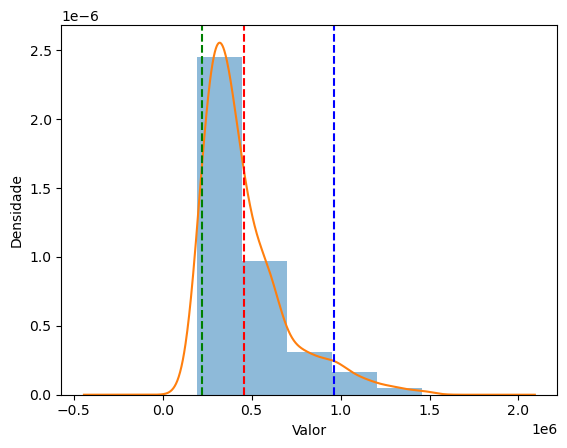

In [32]:
curva_dense(train_trat_v1, 'Applicant_Income')

In [33]:
# Calcular o coeficiente de assimetria de Fisher
#Valor próximo a zero : indica uma distribuição aproximadamente simétrica.
#Valor positivo : indica uma assimetria à direita, com a cauda longa à direita da média.
#Valor negativo : indica uma assimetria à esquerda, com a cauda longa à esquerda da média.
#Quanto maior o valor absoluto do coeficiente, maior é a magnitude da assimetria.

coef_assimetria = train_trat_v1['Applicant_Income'].skew().round(2)
print(coef_assimetria)

6.54


In [34]:
# Calcular o coeficiente de curtose de Fisher
#Valor próximo a zero : indica uma distribuição aproximadamente normal.
#Valor positivo : indica uma distribuição mais concentrada, com caudas pesadas e picos mais altos.
#Valor negativo : indica uma distribuição menos concentrada, com caudas leves e picos mais baixos.
#Quanto maior o valor absoluto da curtose, mais diferente é a distribuição em relação à distribuição normal.

coef_curtose = train_trat_v1['Applicant_Income'].kurtosis().round(2)
print(coef_curtose)

60.54


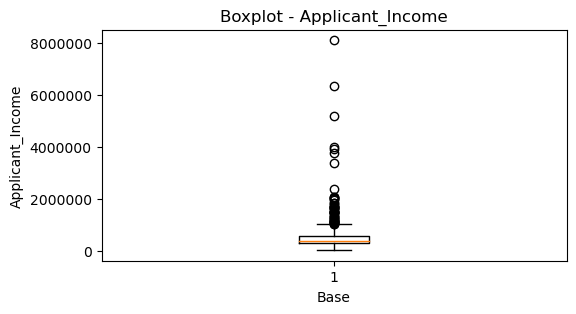

In [35]:
boxplot(train_trat_v1, 'Applicant_Income')

<Figure size 800x600 with 0 Axes>

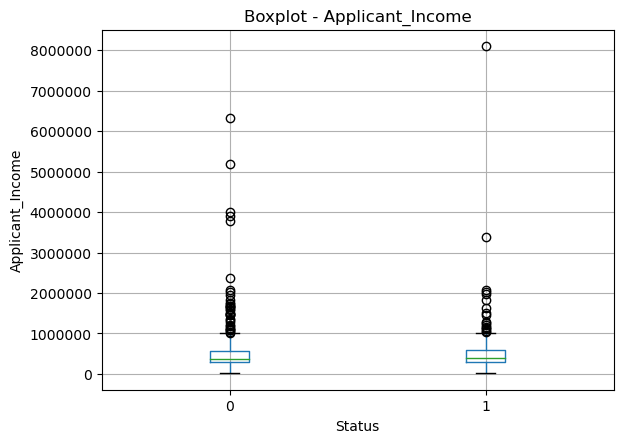

In [36]:
boxplot(train_trat_v1, 'Applicant_Income', 'Status')

- Variável : Coapplicant Income

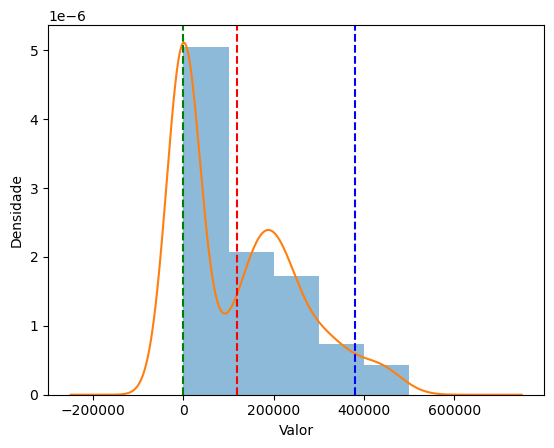

In [37]:
curva_dense(train_trat_v1, 'Coapplicant_Income')

In [38]:
coef_assimetria = train_trat_v1['Coapplicant_Income'].skew().round(2)
coef_curtose = train_trat_v1['Coapplicant_Income'].kurtosis().round(2)
print("Assimetria : ", coef_assimetria)
print("Curtose : ",coef_curtose)

Assimetria :  7.49
Curtose :  84.96


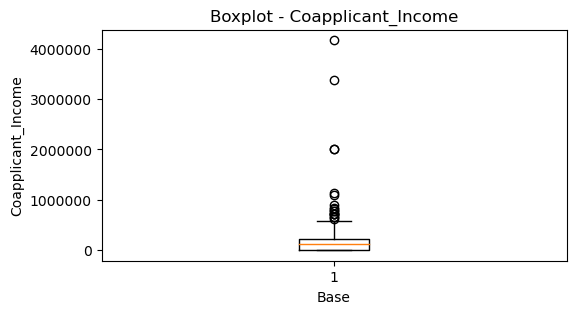

In [39]:
boxplot(train_trat_v1, 'Coapplicant_Income')

<Figure size 800x600 with 0 Axes>

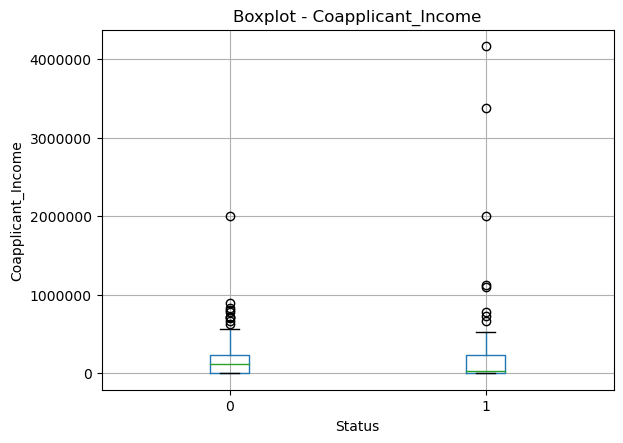

In [40]:
boxplot(train_trat_v1, 'Coapplicant_Income', 'Status')

- Variável : Loan_Amount

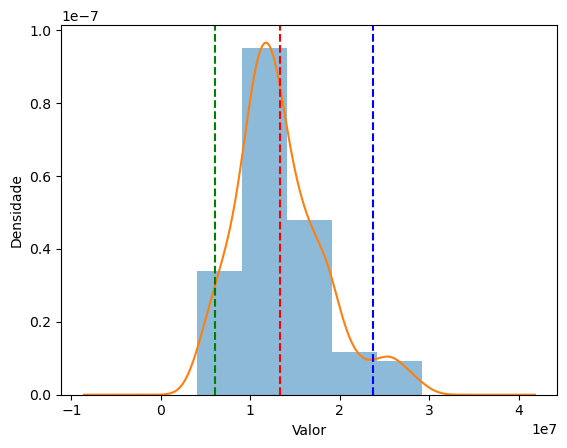

In [41]:
curva_dense(train_trat_v1, 'Loan_Amount')

In [42]:
coef_assimetria = train_trat_v1['Loan_Amount'].skew().round(2)
coef_curtose = train_trat_v1['Loan_Amount'].kurtosis().round(2)
print("Assimetria : ", coef_assimetria)
print("Curtose : ",coef_curtose)

Assimetria :  2.38
Curtose :  9.26


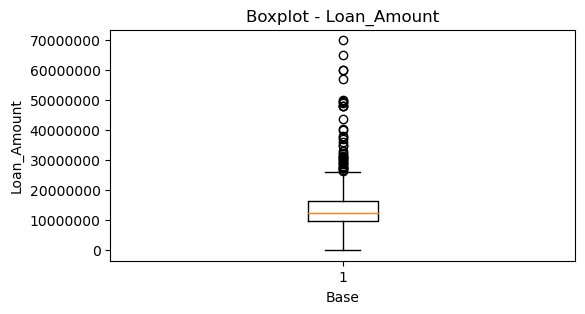

In [43]:
boxplot(train_trat_v1, 'Loan_Amount')

<Figure size 800x600 with 0 Axes>

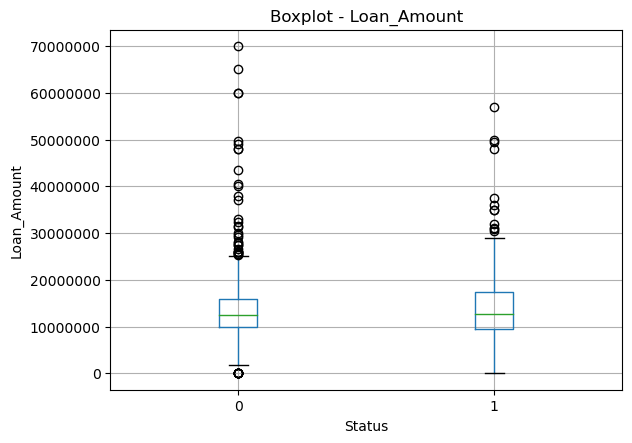

In [44]:
boxplot(train_trat_v1, 'Loan_Amount', 'Status')

## Resumo Distribuições : 
     
    Applicant_Income :
        Curva levemente assimétrica a direita. (6.5)
        Curtose alta = curva leptocúrtica(distrib. alongada). (60.5)
        Distribuição semelhante em relação a variável alvo :
        até 1MM com outliers até 8MM.
        
    Coapplicant Income : 
        Curta levemente assimétrica a direita. (7.4)
        Alta Curtose = leptocúrtica.
        Distribuição diferentes : 
        para y1 temos um acumulo de 50% da base quase 0, e outliers mais espaçados.
        para y0 a base se demonstra mais distribuída entre 0 e 700k~

    Loan Amount : 
        Curta muito levemente assimétrica a direita. (2.3)
        Curtose leve = leptocúrtica ou mesocúrtica ? 
            *Muito próximo de uma curva Normal.
        Distribuição diferentes, ambos tem a mesma mediana (1.3M~), porém 	y1 possuí maior volume entre os valores acima disso.
        max y0 (2.5MM)
        max y1 (3.0MM)

# Variaveis com maior potencial 
- Credit_History (binária)
- Area (categórica)
- Coapplicant Income (numérica)
- Loan Amount (numérica)

# Teste de Hipotese
- Associação Qui-Quadrado + Magnitude : vars x variavel alvo
    
- Pergunta : Há associação/correlação estatística entre as variáveis ?

        H0: as variáveis se associam de forma aleatória.
        H1: a associação entre as variáveis não se dá de forma aleatória.

## Area possuí associação significativa com a variável Alvo ?
- Teste Qui-quadrado + Cramer

In [45]:
contingency = pd.crosstab(train_trat_v1['Area'], train_trat_v1['Status'])
contingency

Status,0,1
Area,,
Rural,110,69
Semiurban,179,54
Urban,133,69


In [46]:
# Realizar o teste qui-quadrado
chi2, p_value, _, _ = chi2_contingency(contingency)

print("Estatística Qui-Quadrado:", chi2.round(3))
print("Valor P:", p_value.round(3))
#P-valor = 0.002, ou seja, dado o nível de significância de 0.05, Há evidências estatísticas para rejeitar a hipótese nula de que as duas variáveis são independentes. 

Estatística Qui-Quadrado: 12.298
Valor P: 0.002


In [47]:
# Calcular o coeficiente de contingência (Cramér's V) = medidor de magnitude da associação

n = contingency.sum().sum()
#calcular a soma total dos valores em uma tabela de contingência

v = (chi2 / n) ** 0.5
# Divide o valor do qui-quadrado (chi2) pelo valor de n, que representa a soma total dos valores na tabela de contingência. O resultado dessa divisão é a estatística do qui-quadrado padronizada.
# O operador ** é usado para elevar o resultado dessa divisão a 0.5. Essa etapa é realizada para calcular a raiz quadrada do valor.
# O resultado dessa operação é atribuído à variável v, que representa o coeficiente de contingência (Cramér's V).

print('Coeficiente de contingência (Cramér\'s V):', v.round(3))
#Quanto mais próximo o valor de V estiver de 0, menor será a associação entre as variáveis, e quanto mais próximo de 1, maior será a associação.

Coeficiente de contingência (Cramér's V): 0.142


## Credit History possuí associação significativa com a variável Alvo ?
- Teste Qui-quadrado + Coef.Phi

In [48]:
contingency = pd.crosstab(train_trat_v1['Credit_History'], train_trat_v1['Status'])
chi2, p_value, _, _ = chi2_contingency(contingency)

print("Estatística Qui-Quadrado:", chi2.round(3))
print("Valor P:", p_value, " -> round : ", p_value.round())

Estatística Qui-Quadrado: 112.695
Valor P: 2.5162224058605992e-26  -> round :  0.0


In [49]:
# Coeficiente Phi: É uma medida de associação que varia de -1 a 1. É uma versão padronizada do coeficiente de contingência e é usado especificamente para tabelas de contingência 2x2.
phi = math.sqrt(chi2 / contingency.sum().sum())
print("Coeficiente Phi:", round(phi,3))

Coeficiente Phi: 0.428


## Loan Amount possuí associação significativa com a variável Alvo ?
- Teste de Mann-Whitney U : teste não paramétrico para variáveis num(que não apresentam curva normal) + binária 

- Exemplo sem remoção de Outliers

In [50]:
# Separar os grupos por gênero
y_0 = train_trat_v1[train_trat_v1['Status'] == 0]['Loan_Amount']
y_1 = train_trat_v1[train_trat_v1['Status'] == 1]['Loan_Amount']

# Realizar o teste de Mann-Whitney U
statistic, p_value = mannwhitneyu(y_0, y_1)

# Imprimir os resultados
print("Estatística U de Mann-Whitney:", statistic)
print("Valor p:", p_value)

Estatística U de Mann-Whitney: 40262.0
Valor p: 0.9025430841867879


 - Exemplo removendo outliers

In [51]:
# Separar os grupos por gênero
y_0 = train_trat_v1[train_trat_v1['Status'] == 0]
inf = y_0['Loan_Amount'].quantile(0.05)
sup = y_0['Loan_Amount'].quantile(0.95)
y_0 = y_0[(y_0['Loan_Amount'] >= inf) & (y_0['Loan_Amount'] <= sup)]['Loan_Amount']

y_1 = train_trat_v1[train_trat_v1['Status'] == 1]
inf = y_1['Loan_Amount'].quantile(0.05)
sup = y_1['Loan_Amount'].quantile(0.95)
y_1 = y_1[(y_1['Loan_Amount'] >= inf) & (y_1['Loan_Amount'] <= sup)]['Loan_Amount']

# Realizar o teste de Mann-Whitney U
statistic, p_value = mannwhitneyu(y_0, y_1)

# Imprimir os resultados
print("Estatística U de Mann-Whitney:", statistic)
print("Valor p:", p_value)

Estatística U de Mann-Whitney: 35964.0
Valor p: 0.3826528499267541


## Coapplicant_Income possuí associação significativa com a variável Alvo ?
- Teste de Mann-Whitney U : teste não paramétrico para variáveis num(que não apresentam curva normal) + binária 

In [52]:
# Separar os grupos por gênero
y_0 = train_trat_v1[train_trat_v1['Status'] == 0]
inf = y_0['Coapplicant_Income'].quantile(0.05)
sup = y_0['Coapplicant_Income'].quantile(0.95)
y_0 = y_0[(y_0['Coapplicant_Income'] >= inf) & (y_0['Coapplicant_Income'] <= sup)]['Coapplicant_Income']

y_1 = train_trat_v1[train_trat_v1['Status'] == 1]
inf = y_1['Coapplicant_Income'].quantile(0.05)
sup = y_1['Coapplicant_Income'].quantile(0.95)
y_1 = y_1[(y_1['Coapplicant_Income'] >= inf) & (y_1['Coapplicant_Income'] <= sup)]['Coapplicant_Income']

# Realizar o teste de Mann-Whitney U
statistic, p_value = mannwhitneyu(y_0, y_1)

# Imprimir os resultados
print("Estatística U de Mann-Whitney:", statistic)
print("Valor p:", p_value)

Estatística U de Mann-Whitney: 38140.5
Valor p: 0.3285687536295008


## Resumo Hipoteses : 
    Area : Hipotese válida, porém com baixa magnitude.
    Credit History : Hipotese válida, com maginitude moderada positiva.
    Loan Amount : Hipotese Nula.
    Coapplicant_Income : Hipotese Nula.